# HW 11: Assignment 2 - CLUSTERING BUSINESS


### Author: Avikal Somvanshi



## Importing packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as plt
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
import zipfile
import seaborn
import os
from sklearn import mixture
%matplotlib inline

print (os.getenv("PUIDATA"))

/home/cusp/as10724/PUIdata


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## TASKS - 1. Get and prep your data


In [2]:
#downloading using code from the the instructions

#!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#!for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


In [3]:
#additionally downloading data for 2000-01 as it did not get downloaded using original code

#for i in range(2):
    #os.system('curl -o ' + os.getenv('PUIDATA') + '/zbp0' + str(i) + 'totals.zip' + \
             # ' ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0' + str(i) + 'totals.zip')

In [4]:
#recalling NY zipcode file from nyc open data and extracting nyc
zipcode = pd.read_csv('https://data.ny.gov/api/views/juva-r6g2/rows.csv')
nyc_zip = zipcode[zipcode['County Name'] == 'New York']
nyc_zip = nyc_zip.append(zipcode[zipcode['County Name'] == 'Queens'])
nyc_zip = nyc_zip.append(zipcode[zipcode['County Name'] == 'Kings'])
nyc_zip = nyc_zip.append(zipcode[zipcode['County Name'] == 'Bronx'])
nyc_zip = nyc_zip.append(zipcode[zipcode['County Name'] == 'Richmond'])
nyc_zips = (nyc_zip['ZIP Code'])

In [5]:
#preaping data 
business_data = pd.DataFrame()
for i in range (1994,2015):
    filename = 'zbp' + (str(i)[2:]) + 'totals.zip'
    zips = zipfile.ZipFile(os.getenv('PUIDATA') + '/hw11/' + filename)
    data = pd.read_csv(zips.open(filename.replace('.zip','.txt')))
    data.columns = [x.lower() for x in data.columns]
    data['year'] = i
    data  = data[data['zip'].isin(nyc_zips)]
    data = data[['zip', 'est', 'year']]
    business_data = business_data.append(data)
business_data.reset_index(inplace=True)
business_data.drop('index', axis=1, inplace=True)
business_data.head()

,zip,est,year
0,10001,6999,1994
1,10002,1784,1994
2,10003,3256,1994
3,10004,1115,1994
4,10005,1076,1994


In [6]:
#pivoting dataframe
business_data_pivoted = business_data.pivot(index='zip', columns='year', values='est')
business_data_pivoted.dropna(inplace=True)
business_data_pivoted.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [7]:
#saving a transposed dataframe to carryout standardization
data_stan = business_data_pivoted.T
data_stan.columns

Int64Index([10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009,
            10010,
            ...
            11451, 11559, 11580, 11690, 11691, 11692, 11693, 11694, 11695,
            11697],
           dtype='int64', name='zip', length=274)

In [8]:
#Whitening the data
for i in data_stan.columns:
    data_stan[i] = [(j-data_stan[i].mean()) / data_stan[i].std() for j in data_stan[i]]
    
data_stan.head()

zip,10001,10002,10003,10004,10005,10006,10007,10008,10009,10010,...,11451,11559,11580,11690,11691,11692,11693,11694,11695,11697
year,,,,,,,,,,,,,,,,,,,,,
1994,-1.839191,-1.713540,-1.820497,-1.512649,-2.819347,1.576901,-0.444220,0.025796,-1.695218,-0.589198,...,-1.134733,1.252950,1.194520,-0.845154,-0.805023,-0.947361,-0.458450,-0.842815,2.248830,-1.541458
1995,-1.193297,-1.626405,-1.434653,-1.438217,-2.263972,0.902719,-0.717132,0.134140,-1.700614,-1.026701,...,-1.134733,2.013670,1.851326,2.919624,-0.967353,-0.854828,-0.710477,-1.375564,1.746431,-1.716434
1996,-1.287641,-1.377447,-1.307101,-1.363786,-0.463213,0.525634,-0.882533,0.134140,-1.484761,-0.452478,...,-1.134733,2.103166,1.699755,0.230497,-0.689073,-0.484696,-0.811288,-1.257175,1.746431,-1.366482
1997,-0.714319,-1.053802,-0.930824,-1.032980,-0.278088,0.765597,-0.609621,0.892547,-1.085433,0.682297,...,-0.218218,0.894964,0.916641,-1.382980,-0.851403,-0.299630,-1.063315,-0.842815,0.741635,-0.666576
1998,0.011404,-1.168323,-0.567301,-1.008170,0.445582,1.222670,-0.650971,0.675860,-0.874976,1.229177,...,-0.218218,0.447482,0.512453,-0.307329,-1.129683,-0.669762,-1.264937,-1.020398,0.239237,-0.666576


In [9]:
#saving the standardised data in a new dataframe
business_data_pivot = data_stan.T
business_data_pivot.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


## TASKS - 2. Cluster the NUMBER OF ESTABLISHMENTS time series with K-means


In [10]:
# using eblow function as defined in the ADS lab to determine optimum cluster numbers

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

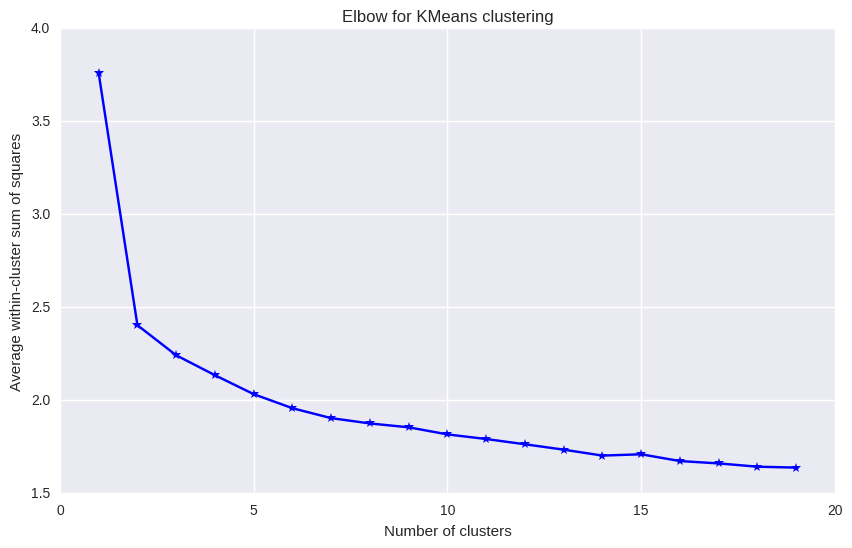

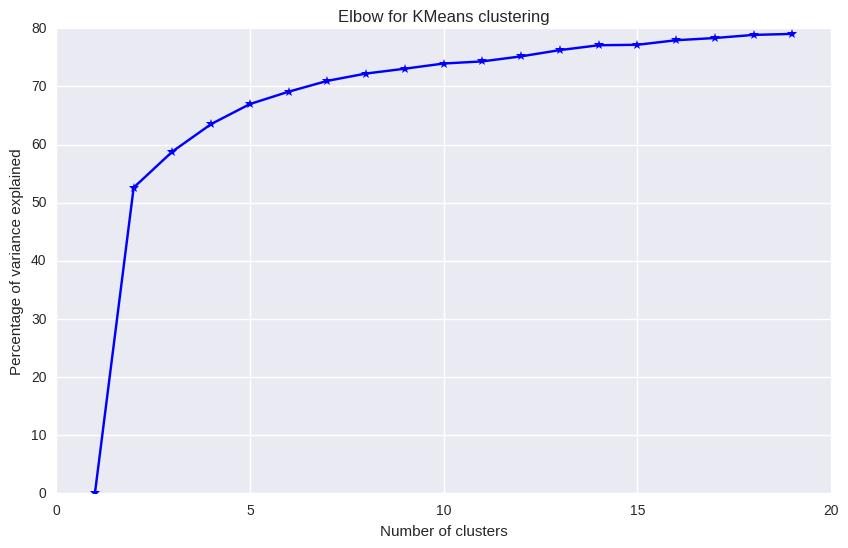

In [11]:
#running KMeans Clustering analysis
elbow(business_data_pivot, range(1,20))

### Figure: Based on the elbow analysis for K-Mean clustering the optimum number of clusters would be 2 (visual inspection)

## Based on the elbow analysis for K-Mean clustering the optimum number of clusters is 2 but instructions explicitly say to choose a number higher than 2, but there is no clear best fit therefore I'm going to proceed with 5 clusters.

In [12]:
# Clustering data using K-means (n=4) and adding labels to dummy census business data
bdp = business_data_pivot.copy() #dummy census business dataframe to store lables
n = 5
km = KMeans(random_state=1988,n_clusters=n)
fit_km = km.fit(business_data_pivot)
bdp['km_label'] = fit_km.labels_
bdp.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,km_label
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,2
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,2
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,2
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,2


## TASKS - 3. Plot the cluster centers



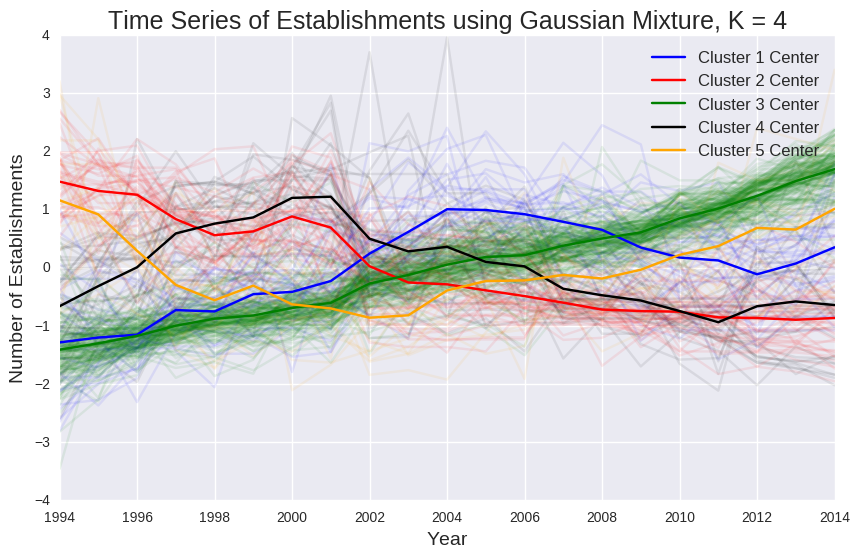

In [13]:
# KMean Clustering Visualization
fig = plt.figure(1, figsize=(10, 6))
colors = ['blue', 'red', 'green', 'black', 'orange']
val = [int(j) for j in business_data_pivot.columns]

for i in range(len(business_data_pivot)):
    plt.plot(val, business_data_pivot.iloc[i], c=colors[bdp.km_label.iloc[i]], 
             alpha=0.08, label='_zipcode time series')  


plt.plot(val, fit_km.cluster_centers_[0], c=colors[0], label='Cluster 1 Center')
plt.plot(val, fit_km.cluster_centers_[1], c=colors[1], label='Cluster 2 Center')
plt.plot(val, fit_km.cluster_centers_[2], c=colors[2], label='Cluster 3 Center')
plt.plot(val, fit_km.cluster_centers_[3], c=colors[3], label='Cluster 4 Center')
plt.plot(val, fit_km.cluster_centers_[4], c=colors[4], label='Cluster 5 Center')

plt.ylabel('Number of Establishments', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks((np.arange(1994, 2015, 2)))
plt.xlim(1994, 2014)
plt.title("Time Series of Establishments using Gaussian Mixture, K = 4", fontsize=18)
plt.legend(fontsize=12)

#### Figure: Plot shows the time series clustering of business establishments by KMeans method in NYC. Cluster 1 has significantly higher density and upward movement of business establishments compared to rest.  


## TASKS - 4. Use another clustering algorithm (of your choice)
    


### Gaussian Mixture Clustering


In [14]:
# Clustering data using gaussian mixture clustering and adding labels

n = 5
gm = mixture.GMM(n_components=n, random_state=2006)
fit_gm = gm.fit(business_data_pivot)
bdp['gm_label'] = fit_gm.fit_predict(business_data_pivot)
bdp.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,2014,km_label,gm_label
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0,0
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,2,2
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,2,2
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,2,2
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,2,4


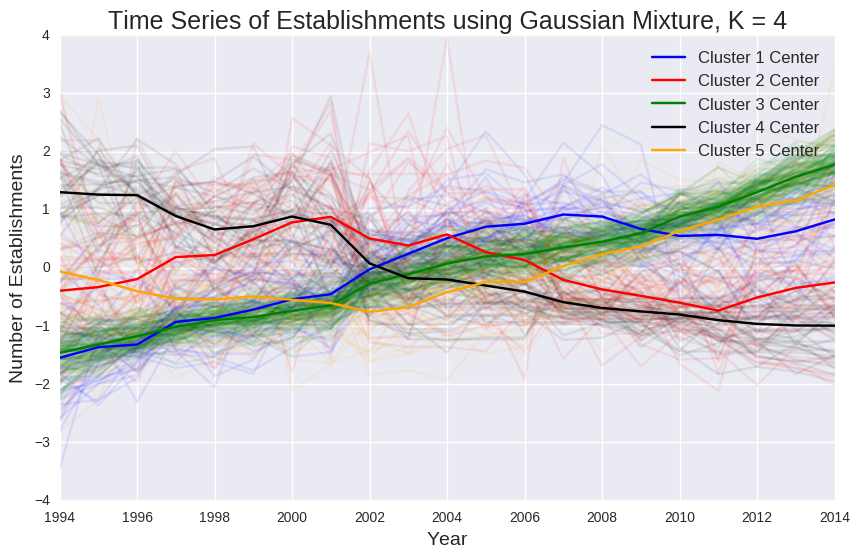

In [15]:
# Gaussian Mixture Clustering Visualization
fig = plt.figure(1, figsize=(10, 6))
colors = ['blue', 'red', 'green', 'black', 'orange']
val = [int(j) for j in business_data_pivot.columns]

for i in range(len(business_data_pivot)):
    plt.plot(val, business_data_pivot.iloc[i], c=colors[bdp.gm_label.iloc[i]], 
             alpha=0.08, label='_zipcode time series')  


plt.plot(val, fit_gm.means_[0], c=colors[0], label='Cluster 1 Center')
plt.plot(val, fit_gm.means_[1], c=colors[1], label='Cluster 2 Center')
plt.plot(val, fit_gm.means_[2], c=colors[2], label='Cluster 3 Center')
plt.plot(val, fit_gm.means_[3], c=colors[3], label='Cluster 4 Center')
plt.plot(val, fit_gm.means_[4], c=colors[4], label='Cluster 5 Center')

plt.ylabel('Number of Establishments', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks((np.arange(1994, 2015, 2)))
plt.xlim(1994, 2014)
plt.title("Time Series of Establishments using Gaussian Mixture, K = 4", fontsize=18)
plt.legend(fontsize=12)

#### Figure: Plot shows the time series clustering of business establishments by Gaussian Mixture method in NYC.  Cluster 3 has significantly higher density and upward movement of business establishments compared to rest.  Cluster 5 also shows upward movement similar to Cluster 3 but has lesser density. 

## This plot is different from KMeans visiually. It seems to have clustered the zipcodes in clusters which are more diverse within. 


## TASKS - 5. Overlay your data on a NYC map


In [16]:
# importing shape file for NYC
nyc_shape = gpd.read_file(os.getenv('PUIDATA')+ "/hw11/nyc-zip-code-tabulation-areas-polygons.geojson")
nyc_shape.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [17]:
# renaming columns to facilitate merger
nyc_shape['zipcode_int'] = nyc_shape['postalCode'].astype(int)

In [18]:
# Merge cluster labels into nyc_shape
cluster_labels = bdp[['km_label', 'gm_label']]
nyc_shape_clusters = nyc_shape.merge(cluster_labels, left_on='zipcode_int', right_index=True)
nyc_shape_clusters.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode,zipcode_int,km_label,gm_label
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,11372,2,2
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,11004,2,0
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,11040,2,4
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,11426,4,4
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,11365,2,2


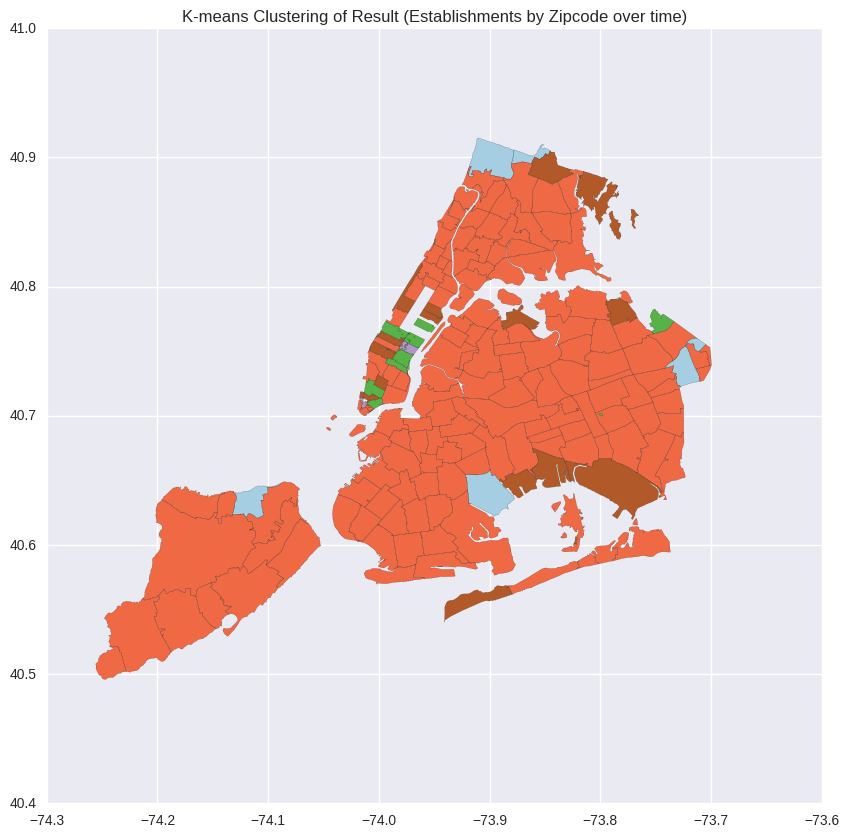

In [19]:
# Visualising KMean Clustering results
f, ax = plt.subplots(figsize=(10,10))
nyc_shape_clusters.plot(column='km_label', cmap='Paired_r', alpha=1, linewidth=0.1, ax=ax)
ax.set_title("K-means Clustering of Result (Establishments by Zipcode over time)")

#### Figure: Color map shows the spatial clustering of zipcodes by number of business establishments using KMeans method in NYC.  


## TASKS -  6. Compare the results of the algorithms
    


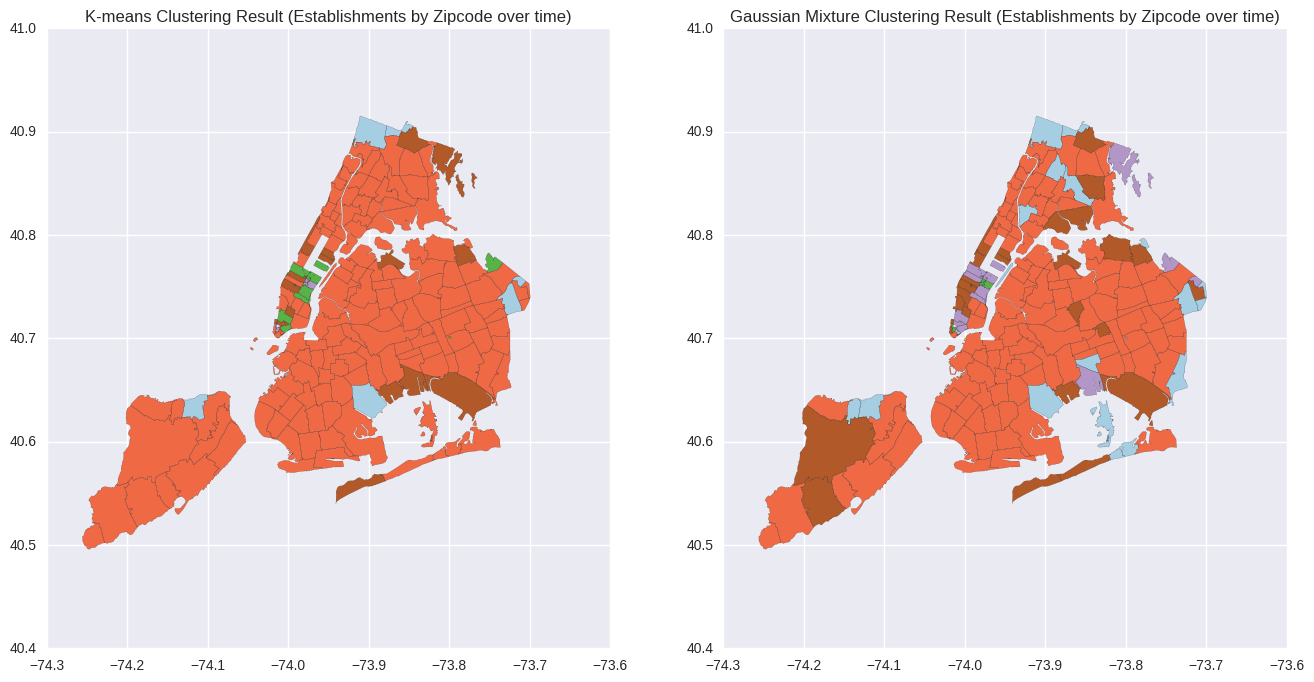

In [20]:
#Visualising all four clustering results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
nyc_shape_clusters.plot(column='km_label',cmap='Paired_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("K-means Clustering Result (Establishments by Zipcode over time)")
nyc_shape_clusters.plot(column='gm_label',cmap='Paired_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Gaussian Mixture Clustering Result (Establishments by Zipcode over time)")

#### Figure: Color map shows the spatial clustering of zipcodes by number of NYC business establishments using KMeans and Gaussian Mixture(GM) methods. GM clustering looks to be more spatially diverse compared to one in KMeans clustering.


## TASKS - 7. Attempt an interpretation


The analysis shows that most business are concntrated around Lower and Middle Manhattan followed by the airports. Gaussian Mixture (GM) clustering also indicates that some zipcodes in Queens and Bronx have growing businesses. I'm tempted to interpret that KMeans clustering shows more static picture of the city, while GM clustering captures growth trend over time. But this is still based on visual observation, therefore cannot be considered scientific. 